In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GCNConv

from visualization_tools import plot_soccer_pitch
from visualization_tools import animate_run
from visualization_tools import plot_spatial_graph


# Data loaded via the `collect_all_data` function in `get_data.py`

In [2]:
match_info = pd.read_csv("data/matches_info.csv")
possessions = pd.read_csv("data/possessions.csv")
run_features = pd.read_csv("data/run_features.csv")
tracking_data = pd.read_csv("data/tracking_data.csv")
player_to_team = pd.read_csv("data/player_team.csv").set_index("id")

merged = pd.merge(possessions,run_features,on=["match_id","possession_index"],how="outer",suffixes=("_possession","_run"))

merged["possession_lead_to_shot"] = (merged["possession_lead_to_shot"] | merged["lead_to_shot"])# Need to update wheter runs and possessions lead to shots on values that conflict
merged["possession_lead_to_goal"] = (merged["possession_lead_to_goal"] | merged["lead_to_goal"])


In [3]:
run_types_to_predict = ['cross_receiver','behind']
runs_to_predict = merged[merged.event_subtype.isin(run_types_to_predict)]

In [4]:
tracking_frame_groups = {
    (mid, rid): df
    for (mid, rid), df in tracking_data.groupby(
        ["match_id", "run_id"]
    )
}

# Validating that we can build graphs for each run

In [5]:
def validate_run(run_row):
    runner_id = run_row["player_id"]
    match_id = run_row["match_id"]
    run_id = run_row["event_id"]

    frame_start = int(run_row["frame_start_run"])
    frame_end = int(run_row["frame_end_run"])

    tracking = tracking_frame_groups[(match_id, run_id)]

    lower_frame = max(frame_start-10,tracking["frame_id"].min())
    
    expected_frames = set(range(lower_frame, frame_end + 1))
    actual_frames = set(tracking["frame_id"].unique().tolist())

    if not expected_frames.issubset(actual_frames):
        return False
    
    runner_per_frame = (
        tracking
        .groupby("frame_id")["player"]
        .apply(lambda players: runner_id in players.values)
    )
    return runner_per_frame.all()
runs_to_predict = runs_to_predict[runs_to_predict.apply(validate_run,axis=1)]

# Build Graph

In [97]:

def build_graph_from_frame(frame_df, runner_player_id, player_to_team):
    """
    frame_df: rows = players at ONE frame_id
    """
    frame_df = frame_df.sort_values("player").reset_index(drop=True)

    player_ids = frame_df["player"].values
    Np = len(player_ids)

    #player nodes

    player_feats = torch.tensor(
        frame_df[[
            "x", "y",
            "dx", "dy",
            "s",
            "d",
            "acceleration",
            "acc_direction"
        ]].values,
        dtype=torch.float
    )

    team_ids = torch.tensor(
        player_to_team.loc[player_ids, "team_id"].values,
        dtype=torch.long
    )

    # runner flag for players
    is_runner_player = torch.tensor(
        (player_ids == runner_player_id).astype(float),
        dtype=torch.float
    ).unsqueeze(1)

    is_runner = torch.cat(
        [is_runner_player, torch.zeros(1, 1)],
        dim=0
    )

    is_ball = torch.zeros(Np + 1, dtype=torch.bool)

    #ball node

    ball_feats = torch.tensor(
        [[
            frame_df["ball_x"].iloc[0],
            frame_df["ball_y"].iloc[0],
            frame_df["ball_dx"].iloc[0],
            frame_df["ball_dy"].iloc[0],
            frame_df["ball_speed"].iloc[0],
            frame_df["ball_speed_direction"].iloc[0],
            frame_df["ball_acceleration"].iloc[0],
            frame_df["ball_acc_direction"].iloc[0],
        ]],
        dtype=torch.float
    )

    #node features

    x = torch.cat([
        player_feats,
        ball_feats
    ], dim=0)

    is_ball[-1] = True
    is_ball_feat = is_ball.float().unsqueeze(1)

    team_ids = torch.cat([
        team_ids,
        torch.tensor([-1])
    ])

    x = torch.cat([
        x,
        is_runner,
        is_ball_feat
    ], dim=1)

    pos = x[:, :2]
    vel = x[:, 2:4]
    N = pos.size(0)

    # Edges an edge attributes
    device = pos.device
    row, col = torch.meshgrid(
        torch.arange(N, device=device),
        torch.arange(N, device=device),
        indexing="ij"
    )

    mask = row != col
    row = row[mask]
    col = col[mask]

    edge_index = torch.stack([row, col], dim=0)

    rel_pos = pos[col] - pos[row]              
    dist = torch.norm(rel_pos, dim=1)           

    direction = rel_pos / (dist.unsqueeze(1) + 1e-6)

    rel_vel = vel[col] - vel[row]  
    rel_speed = torch.sum(rel_vel * direction, dim=1)

    same_team = (
        (team_ids[row] == team_ids[col]) &
        (team_ids[row] != -1)
    ).float()

    ball_edge = (is_ball[row] | is_ball[col]).float()

    edge_attr = torch.stack(
        [dist, same_team, ball_edge, rel_speed],
        dim=1
    )

    runner_idx = int(
        torch.where(
            torch.tensor(player_ids) == runner_player_id
        )[0].item()
    )

    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        runner_idx=torch.tensor(runner_idx, dtype=torch.long),
        team_ids=team_ids,
        is_ball=is_ball
    )
    

In [98]:
RUN_NUM = 0
RUN_FRAME = 2
run = runs_to_predict.iloc[RUN_NUM]
match_id = run["match_id"]
run_id = run["id"]
player = run["player_id"]

run_tracking = tracking_data[(tracking_data.run_id == run_id) & (tracking_data.match_id == match_id)]
run_tracking["timestamp"] = pd.to_timedelta(run_tracking["timestamp"]).dt.total_seconds()
frame_num = run_tracking["frame_id"].sort_values().iloc[0] + RUN_FRAME
frame_df = run_tracking[run_tracking["frame_id"]==frame_num]


graph = build_graph_from_frame(frame_df=frame_df,runner_player_id=player,player_to_team=player_to_team)
graph

C:\Users\zcoch\AppData\Local\Temp\ipykernel_16704\2430058148.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_tracking["timestamp"] = pd.to_timedelta(run_tracking["timestamp"]).dt.total_seconds()


Data(x=[23, 10], edge_index=[2, 506], edge_attr=[506, 4], runner_idx=21, team_ids=[23], is_ball=[23])

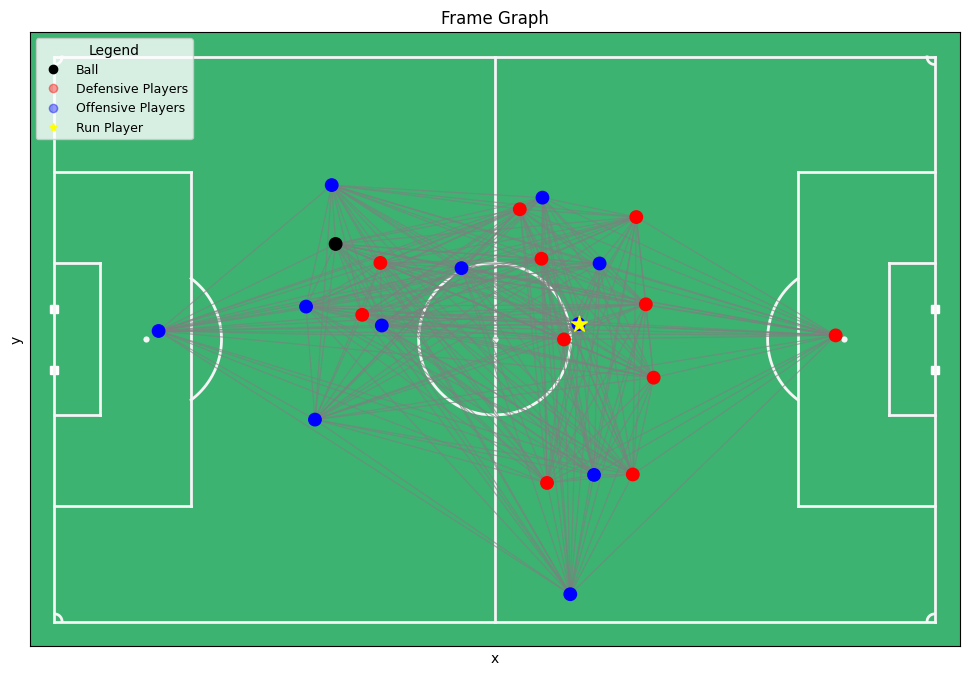

In [99]:
%matplotlib inline
plot_spatial_graph(graph)

# Temporal Dataset class

In [100]:

class TemporalRunnerDataset(Dataset):
    def __init__(self, tracking_df, run_features, player_to_team, samples, T=10, horizon=1):
        self.df = tracking_df
        self.run_features = run_features
        self.player_to_team = player_to_team
        self.samples = samples
        self.T = T
        self.horizon = horizon

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        match_id,run_id, frame_t, runner_id = self.samples[idx]

        graphs = []

        for t in range(frame_t - self.T + 1, frame_t + 1):

            frame_df = self.df[(match_id,run_id)]
            frame_df = frame_df[frame_df["frame_id"]==t]
            try:
                g = build_graph_from_frame(frame_df=frame_df, runner_player_id=runner_id, player_to_team=self.player_to_team,)
            except:
                print(match_id,run_id,t,runner_id)
                print(frame_df.to_markdown())
                raise()

            graphs.append(g)
            
        graphs_batch = Batch.from_data_list(graphs)

        #target is to predict change in x and y
        future = self.df[(match_id,run_id)]
        future = future[(future["frame_id"]==frame_t+self.horizon) & (future["player"] == runner_id)]
        
        target = torch.tensor(
            future[["dx", "dy"]].values.squeeze(),
            dtype=torch.float
        )
        
        lead_to_shot_val = self.run_features.loc[self.run_features['id'] == run_id, 'possession_lead_to_shot'].values
        if len(lead_to_shot_val) == 0:
            shot_label = torch.tensor(0.0) 
        else:
            shot_label = torch.tensor(float(lead_to_shot_val[0]))
        
        lead_to_goal_val = self.run_features.loc[self.run_features['id'] == run_id, 'possession_lead_to_goal'].values
        if len(lead_to_goal_val) == 0:
            goal_label = torch.tensor(0.0) 
        else:
            goal_label = torch.tensor(float(lead_to_goal_val[0]))

        return graphs_batch, target, shot_label, goal_label

def build_samples_from_runs(run_features, T, horizon):
    samples = []

    for _, run in tqdm(run_features.iterrows()):
        match_id = run["match_id"]
        run_id = run["event_id"]
        runner_id = run["player_id"]

        frame_start = int(run["frame_start_run"])
        frame_end = int(run["frame_end_run"])

        # earliest frame we can use (need T past frames)
        frame_df_min = tracking_frame_groups[(match_id,run_id)]["frame_id"].min()
        t_min = frame_start
        t_max = frame_end - horizon

        if t_min > t_max:
            continue 
        if t_min - T < frame_df_min:
            t_min = frame_df_min + T
            
        for t in range(t_min, t_max + 1):
            samples.append(
                (match_id,run_id, t, runner_id)
            )

    return samples


In [101]:
T = 10
horizon = 1

samples = build_samples_from_runs(runs_to_predict, T, horizon)

694it [00:00, 6985.86it/s]


In [103]:
dataset = TemporalRunnerDataset(
    tracking_df=tracking_frame_groups,
    run_features=runs_to_predict,
    player_to_team=player_to_team,
    samples=samples,
    T=10,
    horizon=1,
)
dataset

# Temporal GNN

In [104]:
class TemporalRunnerGNN(nn.Module):
    def __init__(self, node_feat_dim, gnn_hidden_dim, rnn_hidden_dim):
        super().__init__()

        self.gnn1 = GCNConv(node_feat_dim, gnn_hidden_dim)
        self.gnn2 = GCNConv(gnn_hidden_dim, gnn_hidden_dim)

        self.rnn = nn.GRU(
            input_size=gnn_hidden_dim,
            hidden_size=rnn_hidden_dim,
            batch_first=True
        )

        self.pos_head = nn.Linear(rnn_hidden_dim, 2)
        # self.shot_head = nn.Linear(rnn_hidden_dim, 1)

    def forward(self, graphs_batch):
        """
        graphs_batch: PyG Batch containing T graphs (time steps)
        """
        device = next(self.parameters()).device
        graphs_batch = graphs_batch.to(device)

        x, edge_index = graphs_batch.x, graphs_batch.edge_index

        # ---- GNN ----
        x = F.relu(self.gnn1(x, edge_index))
        x = F.relu(self.gnn2(x, edge_index))

        batch_vec = graphs_batch.batch 
        runner_idx = graphs_batch.runner_idx

        T = runner_idx.size(0)
        runner_embeds = []

        for t in range(T):
            node_mask = (batch_vec == t)
            node_indices = node_mask.nonzero(as_tuple=False).view(-1)

            global_runner_idx = node_indices[runner_idx[t]]
            runner_embeds.append(x[global_runner_idx])

        runner_embeds = torch.stack(runner_embeds).unsqueeze(0)

        out, _ = self.rnn(runner_embeds)
        last_out = out[:, -1, :] 

        pred_pos = self.pos_head(last_out).squeeze(0)
        # pred_shot = self.shot_head(last_out).squeeze(0) 
        # pred_shot_prob = torch.sigmoid(pred_shot)
        return pred_pos#, pred_shot


# Training Loop

In [113]:
alpha = 1.0  # weight for shot loss
beta = .01 # weight for encouraging dangerous movement
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TemporalRunnerGNN(node_feat_dim=10, gnn_hidden_dim=64, rnn_hidden_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

dataloader = GeoDataLoader(dataset, batch_size=1, shuffle=True)
num_epochs = 30
model.train()

for epoch in range(num_epochs):
    total_loss = 0

    for graphs, target, shot_label, goal_label in tqdm(dataloader):

        target = target.to(device).squeeze(0)
        shot_label = shot_label.to(device)
        shot_label = goal_label.to(device)

        optimizer.zero_grad()

        pred_pos = model(graphs)
        
        assert pred_pos.shape == target.shape
        # assert pred_shot.shape == shot_label.shape
        
        # pos_weight = 1 + 2 * shot_label + 4 * goal_label

        # loss_pos = pos_weight * F.mse_loss(pred_pos, target)

        # loss_shot = F.binary_cross_entropy_with_logits(pred_shot, shot_label)

        # reward = -beta * (
        #     shot_label + 2 * goal_label
        # ) * torch.log(torch.sigmoid(pred_shot) + 1e-6)

        # loss = loss_pos + alpha * loss_shot + reward
        weight = 1.0 + 2.0 * shot_label + 3.0 * goal_label
        loss = weight * F.mse_loss(pred_pos, target)
        
        """
        loss_pos_raw: to learn motion accuracy
        alpha * loss_shot: supervised learning of runs leading to shots
        beta * log(sigmoid(pred_shot)): bias towards runs with high predicted shot (Dangerous movements)
        """
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: {total_loss / len(dataloader):.4f}")

torch.save(model.state_dict(), "temporal_runner_gnn.pth")


100%|██████████| 21545/21545 [17:05<00:00, 21.02it/s]


Epoch 1: 0.0370


100%|██████████| 21545/21545 [16:43<00:00, 21.46it/s]


Epoch 2: 0.0316


100%|██████████| 21545/21545 [16:38<00:00, 21.57it/s]


Epoch 3: 0.0293


100%|██████████| 21545/21545 [16:44<00:00, 21.46it/s]


Epoch 4: 0.0276


100%|██████████| 21545/21545 [16:46<00:00, 21.41it/s]


Epoch 5: 0.0262


100%|██████████| 21545/21545 [16:46<00:00, 21.41it/s]


Epoch 6: 0.0253


100%|██████████| 21545/21545 [16:46<00:00, 21.40it/s]


Epoch 7: 0.0246


100%|██████████| 21545/21545 [16:12<00:00, 22.15it/s]


Epoch 8: 0.0239


100%|██████████| 21545/21545 [14:55<00:00, 24.06it/s]


Epoch 9: 0.0233


100%|██████████| 21545/21545 [14:51<00:00, 24.18it/s]


Epoch 10: 0.0231


100%|██████████| 21545/21545 [14:31<00:00, 24.73it/s]


Epoch 11: 0.0226


100%|██████████| 21545/21545 [15:24<00:00, 23.30it/s]


Epoch 12: 0.0223


100%|██████████| 21545/21545 [16:15<00:00, 22.10it/s]


Epoch 13: 0.0220


100%|██████████| 21545/21545 [18:51<00:00, 19.04it/s]


Epoch 14: 0.0219


100%|██████████| 21545/21545 [17:25<00:00, 20.60it/s]


Epoch 15: 0.0215


100%|██████████| 21545/21545 [17:50<00:00, 20.13it/s]


Epoch 16: 0.0217


100%|██████████| 21545/21545 [16:21<00:00, 21.95it/s]


Epoch 17: 0.0215


100%|██████████| 21545/21545 [15:29<00:00, 23.19it/s]


Epoch 18: 0.0212


100%|██████████| 21545/21545 [14:26<00:00, 24.88it/s]


Epoch 19: 0.0210


100%|██████████| 21545/21545 [14:31<00:00, 24.73it/s]


Epoch 20: 0.0209


100%|██████████| 21545/21545 [14:47<00:00, 24.28it/s]


Epoch 21: 0.0207


100%|██████████| 21545/21545 [14:59<00:00, 23.96it/s]


Epoch 22: 0.0210


100%|██████████| 21545/21545 [14:14<00:00, 25.23it/s]


Epoch 23: 0.0210


100%|██████████| 21545/21545 [14:14<00:00, 25.22it/s]


Epoch 24: 0.0208


100%|██████████| 21545/21545 [14:26<00:00, 24.87it/s]


Epoch 25: 0.0208


100%|██████████| 21545/21545 [14:12<00:00, 25.28it/s]


Epoch 26: 0.0205


100%|██████████| 21545/21545 [14:27<00:00, 24.83it/s]


Epoch 27: 0.0205


100%|██████████| 21545/21545 [14:11<00:00, 25.31it/s]


Epoch 28: 0.0203


100%|██████████| 21545/21545 [14:52<00:00, 24.14it/s]


Epoch 29: 0.0203


100%|██████████| 21545/21545 [16:10<00:00, 22.21it/s]

Epoch 30: 0.0205


# Load Model From Saved State

In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TemporalRunnerGNN(node_feat_dim=10, gnn_hidden_dim=64, rnn_hidden_dim=32)
model.load_state_dict(torch.load("temporal_runner_gnn.pth"))
model.to(device)
model.eval() 

TemporalRunnerGNN(
  (gnn1): GCNConv(10, 64)
  (gnn2): GCNConv(64, 64)
  (rnn): GRU(64, 32, batch_first=True)
  (pos_head): Linear(in_features=32, out_features=2, bias=True)
)

# Given tracking data and runner id predict optimal run path

In [146]:
model.eval()
T = 10
RUN_NUM = 8
run = runs_to_predict.iloc[RUN_NUM]
match_id = run["match_id"]
run_id = run["event_id"]
runner_id = run["player_id"]
team_id = run["team_id"]
run_start = int(run["frame_start_run"])
run_end = int(run["frame_end_run"])
run_tracking = tracking_frame_groups[(match_id,run_id)]
predicted_run_tracking = run_tracking.copy()
min_run_tracking_frame = run_tracking["frame_id"].min()
lower_frame = max(run_start-T,min_run_tracking_frame)
start_frame = lower_frame+T
frames_to_predict = range(start_frame,run_end+1)


for frame_to_predict in frames_to_predict:
    #create temporal graphs
    graphs = []
    for t in range(frame_to_predict - T + 1, frame_to_predict + 1):
        frame_df = predicted_run_tracking[predicted_run_tracking.frame_id==t]
        graph = build_graph_from_frame(frame_df=frame_df,runner_player_id=runner_id,player_to_team=player_to_team)
        graphs.append(graph)
    graphs_batch = Batch.from_data_list(graphs)
    graphs_batch = graphs_batch.to(device)
    #predict optimal runner direction
    with torch.no_grad():
        pred_pos = model(graphs_batch)
    #probability of run up to this point being involved in shot
    pred_dx, pred_dy = pred_pos
    pred_dx, pred_dy = float(pred_dx),float(pred_dy)
    print([pred_dx,pred_dy])
        

    #update predicted runner positions for next frame prediction
    next_mask = (predicted_run_tracking.frame_id == frame_to_predict + 1) & (predicted_run_tracking.player == runner_id)
    curr_mask = (predicted_run_tracking.frame_id == frame_to_predict) & (predicted_run_tracking.player == runner_id)

    predicted_run_tracking.loc[next_mask,["dx","dy"]] = [pred_dx,pred_dy]
    predicted_run_tracking.loc[next_mask,["x","y"]] = (predicted_run_tracking.loc[curr_mask,["x","y"]] + np.array([pred_dx,pred_dy])).iloc[0].values
    FPS = 10
    #Recalculate the speed and acceleration components with new change in position
    predicted_run_tracking.loc[next_mask,"s"] = np.sqrt(predicted_run_tracking.loc[next_mask,"dx"]**2 + predicted_run_tracking.loc[next_mask,"dy"] **2) * FPS
    predicted_run_tracking.loc[next_mask,"d"] = np.arctan2(predicted_run_tracking.loc[next_mask,"dy"],predicted_run_tracking.loc[next_mask,"dx"])
    predicted_run_tracking.loc[next_mask,"ax"] = np.array([predicted_run_tracking.loc[next_mask,"dx"].iloc[0]- predicted_run_tracking.loc[curr_mask,"dx"].iloc[0]])
    predicted_run_tracking.loc[next_mask,"ay"] = np.array([predicted_run_tracking.loc[next_mask,"dy"].iloc[0]- predicted_run_tracking.loc[curr_mask,"dy"].iloc[0]])
    vx = predicted_run_tracking.loc[next_mask,"dx"]
    vy = predicted_run_tracking.loc[next_mask,"dy"]
    speed_frame = np.sqrt(vx**2 + vy**2).iloc[0]
    eps = 1e-6
    vhat_x = vx / (speed_frame + eps)
    vhat_y = vy / (speed_frame + eps)
    predicted_run_tracking.loc[next_mask,"acceleration"] = (predicted_run_tracking.loc[next_mask,"ax"] * vhat_x + predicted_run_tracking.loc[next_mask,"ay"] * vhat_y)* FPS**2
    predicted_run_tracking.loc[next_mask,"acc_direction"] = np.arctan2(predicted_run_tracking.loc[next_mask,"ay"], predicted_run_tracking.loc[next_mask,"ax"])


[0.5545724630355835, -0.05655759572982788]
[0.5560291409492493, -0.059685759246349335]
[0.5542693138122559, -0.05716918408870697]
[0.557233452796936, 0.0008273795247077942]
[0.5484825372695923, -0.07279665023088455]
[0.5329837799072266, 0.005583912134170532]
[0.5079792737960815, 0.056116700172424316]
[0.5147711634635925, 0.033177927136421204]
[0.5144502520561218, 0.047691360116004944]
[0.5168511867523193, 0.05176587402820587]
[0.517325222492218, 0.043782949447631836]
[0.517349362373352, 0.0427468866109848]
[0.5194541811943054, 0.052479684352874756]
[0.5140008330345154, 0.04392378032207489]
[0.5170097351074219, 0.04147690534591675]
[0.5509592294692993, -0.037569236010313034]
[0.5968493223190308, -0.012726664543151855]
[0.6561926007270813, -0.08913363516330719]
[0.6558617949485779, -0.09099090099334717]
[0.657349705696106, -0.08972269296646118]
[0.6596544981002808, -0.08467835932970047]
[0.6614064574241638, -0.08890364319086075]
[0.6578330993652344, -0.09646434336900711]
[0.7054646015167

# Plot Optimal Run Path

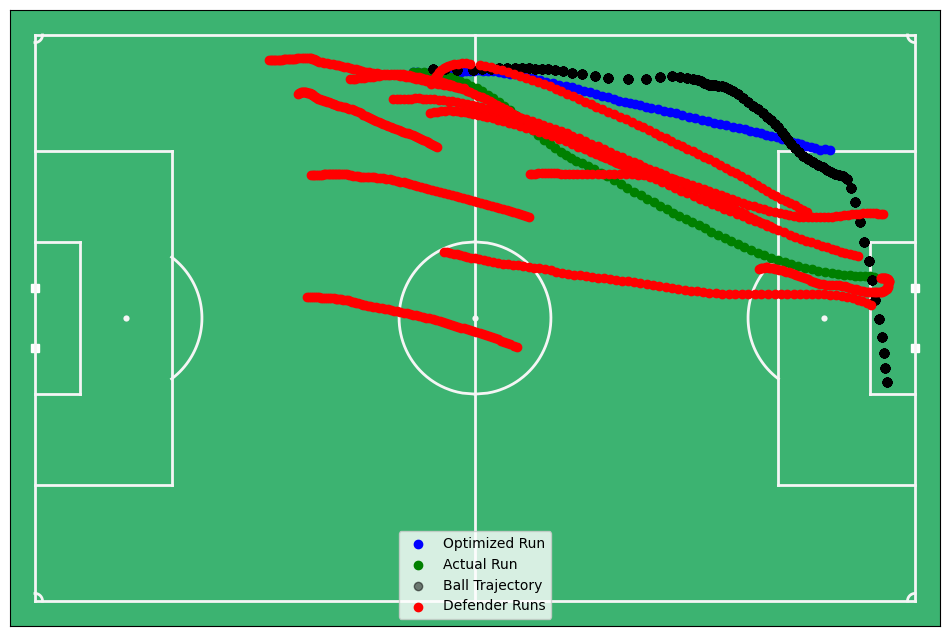

In [147]:
%matplotlib inline
plot_ball = True
plot_defense = True

fig, ax = plot_soccer_pitch()
pred_points = predicted_run_tracking[(predicted_run_tracking.run_active) & (predicted_run_tracking.player == runner_id)][["x","y"]]
pred_x = pred_points.values[:,0]
pred_y = pred_points.values[:,1]
plt.scatter(x=pred_x,y=pred_y,color="blue",label="Optimized Run")

active_run = run_tracking[run_tracking.run_active]
actual_points = active_run[(active_run.player == runner_id)][["x","y"]]
real_x = actual_points.values[:,0]
real_y = actual_points.values[:,1]
plt.scatter(x=real_x,y=real_y,color="green",label="Actual Run")

if plot_ball == True:
    ball_coords = active_run.iloc[:, ["ball" in col for col in active_run.columns]]
    ball_x = ball_coords.loc[:, "ball_x"].values
    ball_y = ball_coords.loc[:, "ball_y"].values
    ax.scatter(ball_x, ball_y, color="black", alpha=0.5, label="Ball Trajectory")

if plot_defense == True:
    defender_frames = active_run[(active_run["player"].apply(lambda id: player_to_team.loc[id])!=team_id).values[:,0]]
    def_x = defender_frames["x"]
    def_y = defender_frames["y"]
    plt.scatter(x=def_x,y=def_y,color="red",label = "Defender Runs")

plt.legend()
plt.show()

# Animate Optimal Run

In [148]:
%matplotlib tk

pred_runner = predicted_run_tracking[predicted_run_tracking.player==runner_id]
pred_runner["player"] = -1
run_tracking_with_pred = pd.concat([run_tracking,pred_runner])
animate_run(run=run,tracking_data=run_tracking_with_pred,player_to_team=player_to_team)

C:\Users\zcoch\AppData\Local\Temp\ipykernel_16704\1418574338.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_runner["player"] = -1
